#  Persistent Homology Tutorial 

Persistent homology is a construct from algebraic topology that formalizes the effect that changing a topological space in a certain way has on its homology. It attempts to overcome the lack of robustness homology shows: changing the space of interest just a little can result in a drastic change in homology. The approach to this is to consider the homology of the space at different "resolutions", so to say -- for example by approximating it by a sequence of chain complexes that grow more and more complicated and accurate. One can then try to distinguish prominent topological features in arbitrary dimensions from the irrelevant ones by discarding the features that are only present at a few resolutions.

[This paper](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.10.5064) introduces the concept and presents the algorithms. See e.g. [this article](http://www.ams.org/journals/bull/2009-46-02/S0273-0979-09-01249-X/) for a deeper survey of the topic.

To use the function, one has to switch to the `topaz` application. See this [tutorial](topaz_tutorial) for a general introduction to `topaz`.

    


In [ ]:
application 'topaz';



## Filtrations

The objects of study are filtrations of chain complexes with finitely many frames. The data structure is templated by the type of matrix used for the description of the boundary maps.

### From Hasse diagrams

A filtration can be initialized by passing the Hasse diagram of the last frame of the filtration and an array containing the degree of each cell, indexed in the same order as the node indexing in the Hasse diagram (without the empty set and the dummy node with index 0, thus shifted by one). Consider this small three-frame example filtration:

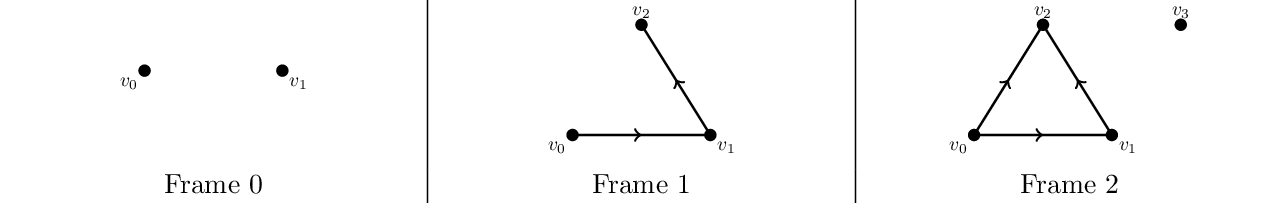

You can construct it in `polymake` like this:

    


In [ ]:
$S = new SimplicialComplex(FACETS=>[[0,1],[0,2],[1,2],[3]]);

In [ ]:
$HD = $S->HASSE_DIAGRAM;              # Hasse diagram of the last frame
print rows_numbered($HD->FACES);      # check indexing

0:-1
1:0 1
2:0 2
3:1 2
4:3
5:0
6:1
7:2
8:


In [ ]:
$a = new Array<Int>(1,2,1,2,0,0,1);   # assign degrees to the simplices ([0,1] gets degree 1, [0,2] degree 2 etc)

In [ ]:
$F = new Filtration<SparseMatrix<Rational>>($HD,$a);



You can print the boundary matrix for each frame and dimension:

    


In [ ]:
print $F->boundary_matrix(1,1);     # print dimension 1 matrix of frame 1

1 -1 0
0 1 -1



To find out which rows correspond to which cells, you can print the cells of the filtration. They will be output as an array of 3-tuples, each representing one cell with degree, dimension and boundary matrix index.

    


In [ ]:
print $F->cells;

(0,0,1) (0,0,2) (1,0,3) (1,1,0) (1,1,2) (2,0,0) (2,1,1)




### From boundary matrices

It is also possible to construct a filtration by passing such an array of cells, together with an array of matrices to be used as boundary matrices. To construct the same filtration as above:

    


In [ ]:
$C = new Array<Cell>(7);
$C->[0] = new Cell(0,0,1);

        $C->[1] = new Cell(0,0,2);
        $C->[2] = new Cell(1,0,3);
        $C->[3] = new Cell(1,1,0);
        $C->[4] = new Cell(1,1,2);
        $C->[5] = new Cell(2,0,0);
        $C->[6] = new Cell(2,1,1);
        


In [ ]:
$bd = new Array<SparseMatrix<Rational>>(3);
$bd->[0] = new SparseMatrix<Rational>([1],[1],[1],[1]);

        $bd->[1] = new SparseMatrix<Rational>([0,1,-1,0],[0,1,0,-1],[0,0,1,-1]);
        $bd->[2] = new SparseMatrix<Rational>();
    


In [ ]:
$F = new Filtration<SparseMatrix<Rational>>($C,$bd);





### Vietoris-Rips filtration

It is also possible to compute the Vietoris-Rips-filtration of a point set given a metric. The input consists of the distance matrix of the point set (that is, the matrix whose i,j-entry is the distance between points i and j), an array containing the filtration degrees of the points, the increase in ball size per frame, and an upper bound to the dimension (so one can compute lower-dimensional skeletons and save space). The following computes the four-skeleton of the VR-filtration of six random points in 5-space using the euclidean metric:

    


In [ ]:
$S = polytope::rand_sphere(5,6)->VERTICES;
$P = $S->minor(All,sequence(1,5));     # dehomogenize

In [ ]:
sub dist($){                          # define euclidean metric
my $v = $_[0] - $_[1];
return sqrt(new Float($v*$v));};

In [ ]:
$D = distance_matrix($P,\&dist);       # conmpute distance matrix of the point set

In [ ]:
$a = new Array<Int>(6);               #zero array -- all points get degree 0

In [ ]:
$F = vietoris_rips_filtration<Rational>($D,$a,0.1,4);



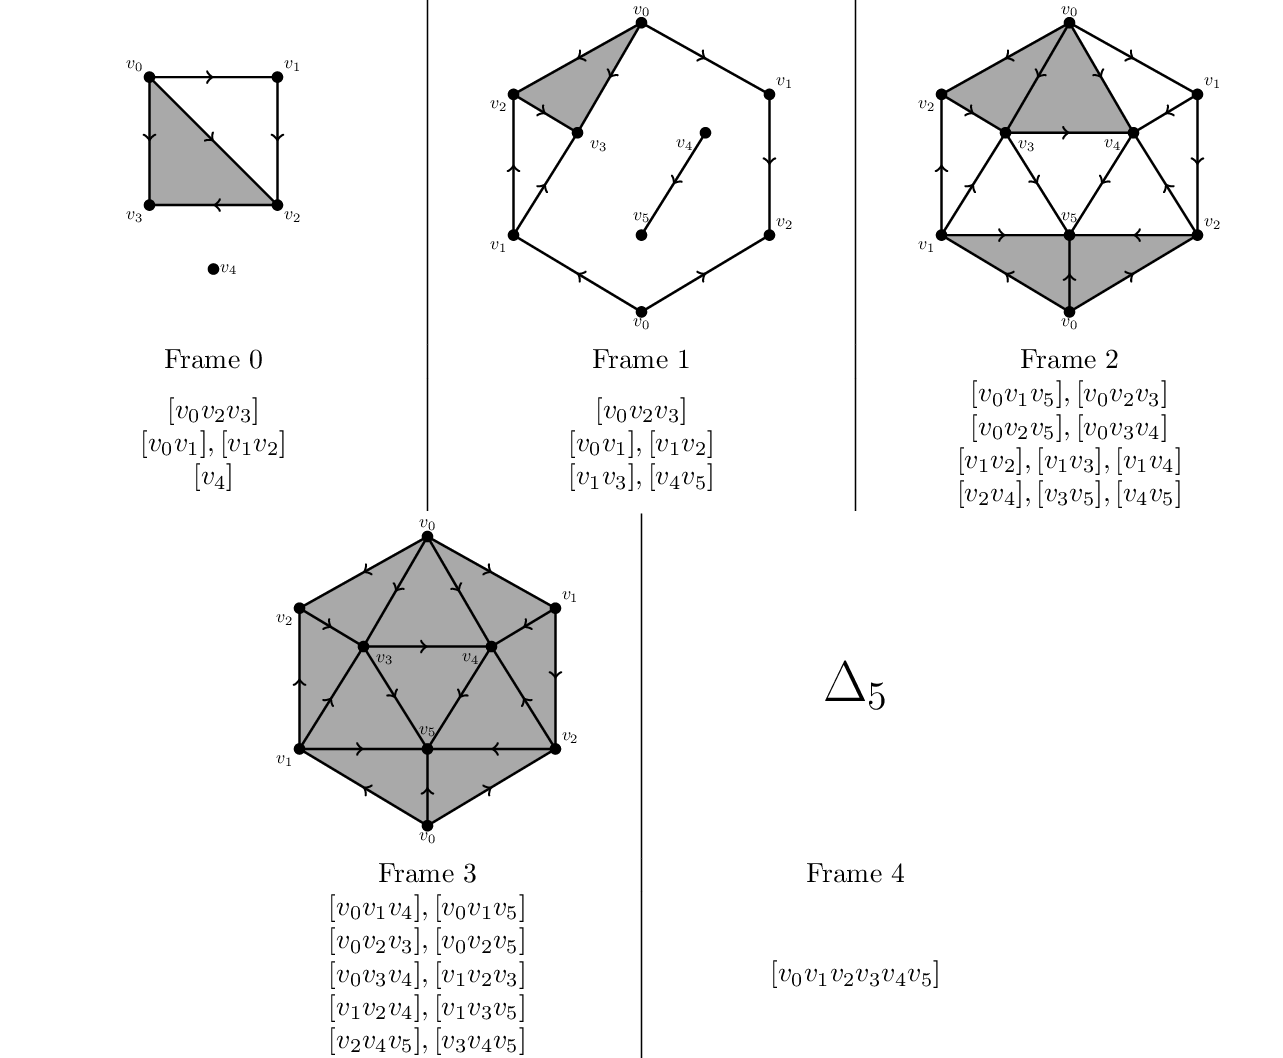
## Computing Persistence

There are two different functions, one to compute persistent homology for coefficients from arbitrary euclidean domains, and another for computing persistence barcodes for field coefficients. Both are templated by the boundary matrix type. The following examples compute both for this filtration of the 5-simplex, whose 3rd frame is the real projective plane:

### Coefficients from arbitrary euclidean domains

The function for coefficients from arbitrary euclidean domains takes as parameters a filtration object matching the matrix type and indices `i,p,k`. It outputs a sparse matrix containing (as rows) the generators of the torsion-free part of the `p`-persistent `k`-th homology group of the `i`-th frame, and a list of paired torsion coefficients and corresponding generator matrices.

The following code loads a filtration object with Integer coefficients containing the example that was previously saved to disk, which you can download {{ :tutorial:filtrationexample.top |here}}. It then computes the 3-persistent first homology group of frame 0, with the result that the torsion-free part is empty, and the part with torsion coefficient 2 has one generator, namely `-v_0+v_1-v_5`:

    
     topaz > $F = load_data("FiltrationExample.top");
     topaz > print persistent_homology<SparseMatrix<Integer>>($F,0,3,1);
    <>
    <(2, <(15) (0 -1) (1 1) (5 -1)>)>


### Field coefficients and barcodes

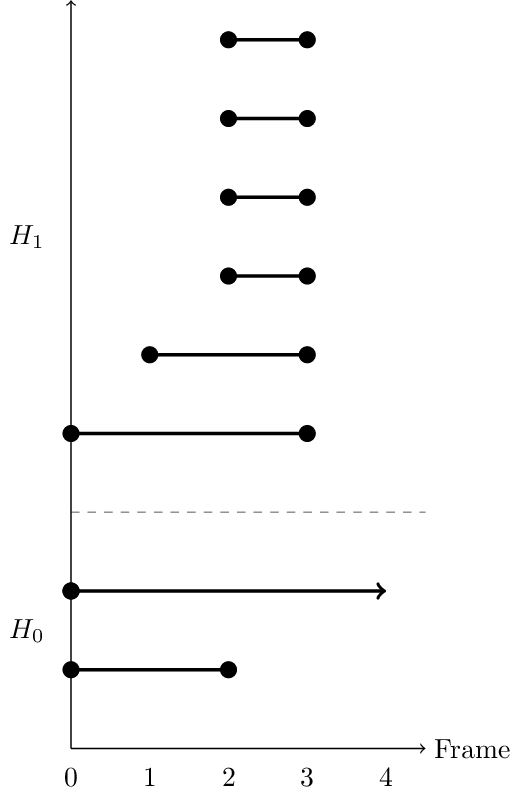The function for field coefficients requires only a filtration object of matching type as parameter. The output is an array with an entry for each dimension, containing a list of persistence intervals encoded as tuples of integers (where -1 encodes infinite lifetime). The following computes the intervals of the same filtration as above but with rational coefficients, downloadable {{ :tutorial:filtrationexamplerational.top |here}}.

    
     topaz > $F2 = load_data("FiltrationExampleRational.top");
     topaz > print persistent_homology<SparseMatrix<Rational>>($F2);
    {(0 2) (0 -1)}
    {(2 3) (2 3) (2 3) (1 3) (2 3) (0 3)}
    {}
    {}
    {}
    {}
    {}


The output corresponds to the barcode on the right.
